In [3]:
import numpy as np
import sys, os 
sys.path.append('../Netket/')
sys.path.append('../ClusterExpansion/')
import netket as nk
import itertools
import matplotlib.pyplot as plt 
from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

ERROR:2026-01-21 13:48:03,087:jax._src.xla_bridge:475: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 473, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load 

∣NK⟩ Tip: log(ψ) ∈ ℜ → ψ = exp(logψ) ∈ ℜ₊ (real NN gives only positive wave-function).

In [4]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'
data_dirs_set = ['data_optimal_basis_rbm', 'extended_data_optimal_basis_rbm']
datadirs = [f'{data_root}/data/{data_dir_val}' for data_dir_val in data_dirs_set]
h5_files_opt = [f'{data_root}/data/{data_dir_val}/{fp}' for data_dir_val in datadirs for fp in os.listdir(data_dir_val) if fp.endswith('.h5')]

df_opt = analysis.load_outputs_to_dataframe_mult_thread(h5_files_opt, load_eigenstates=False, num_workers=4)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

700


In [5]:
features = list(hypotheses.keys())
traindf = df_opt[features + ['infidelity']].dropna()
traindf = traindf[traindf['infidelity'] <  0.6]
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['infidelity'], test_size=0.8, random_state=42)
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

Mean Squared Error: 0.026533446206458117
Percentage error in prediction: 969.3860479149819


In [6]:
traindf.head()

,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,infidelity
0,0.179447,0.000042,0.978425,10.079338,0.761920,0.003465,0.000958
1,0.548042,0.000019,0.997826,10.877749,0.703497,0.003803,0.010293
2,0.571434,0.000234,0.955055,8.359235,0.475908,0.003180,0.077553
3,1.630023,0.000041,0.990663,10.113691,0.000204,0.003188,0.501937
4,0.409339,0.000042,0.980519,10.073536,0.705761,0.003542,0.006239


In [41]:
# features = list(hypotheses.keys())
# features = ['uniform_state_overlap']
features = ['uniform_state_overlap', 'std_phase']
traindf = df_opt[features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.05]
print(len(traindf))
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['Delta_E'], test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error on training set prediction : ', mean_squared_error(y_train, y_pred_train))
print('Perecentage error in training set prediction :', 100 * np.mean(np.abs(y_train - y_pred_train) / y_train))
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

646
516 130
Mean Squared Error on training set prediction :  1.1471723953067722e-05
Perecentage error in training set prediction : 56.80699576033952
Mean Squared Error: 8.331527441457304e-05
Percentage error in prediction: 118.14319052662165


130


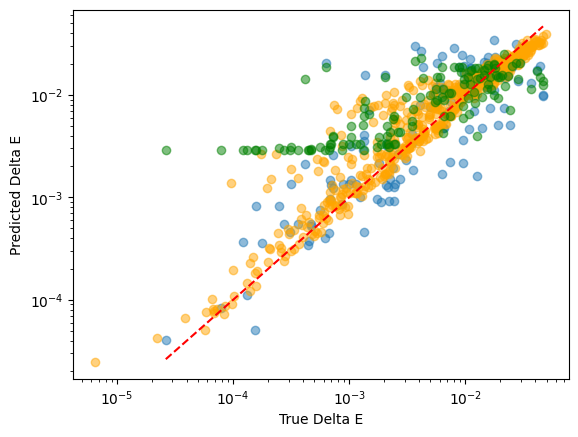

In [49]:
fig, ax = plt.subplots()
print(len(y_test))
ax.scatter(y_test, y_pred, alpha=0.5)
ax.scatter(y_train, y_pred_train, alpha=0.5, color='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
# ax.scatter(df_opt['Delta_E'], df_opt["uniform_state_overlap"],color='red',alpha=0.5)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')

In [48]:
xgbmodel = XGBRegressor(n_estimators=10000, 
                        random_state=42, 
                        learning_rate=0.001, 
                        early_stopping_rounds=100
                        )
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgbmodel.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGB Mean Squared Error: {mse_xgb}") 
print("XGB Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred_xgb) / y_test))

XGB Mean Squared Error: 6.623613212214331e-05
XGB Percentage error in prediction: 388.8535422832513


/tmp/ipykernel_3551467/3132712206.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=45, ha='right')
/tmp/ipykernel_3551467/3132712206.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=45, ha='right')


Text(0, 0.5, 'Feature Importance (RF)')

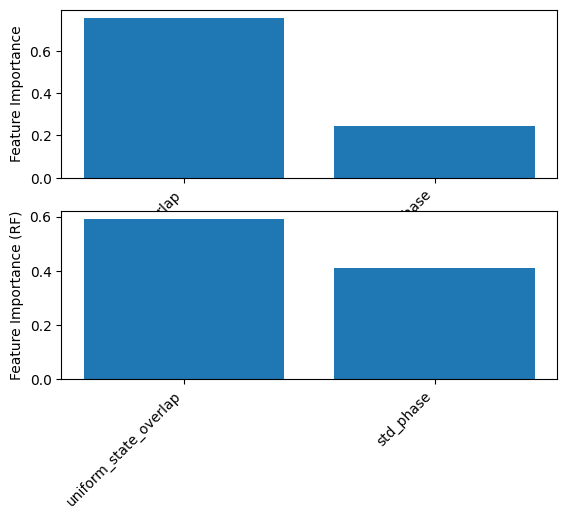

In [35]:
fig, ax = plt.subplots(2)
ax[0].bar(features, xgbmodel.feature_importances_)
ax[0].set_xticklabels(features, rotation=45, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, model.feature_importances_)
ax[1].set_xticklabels(features, rotation=45, ha='right')
ax[1].set_ylabel('Feature Importance (RF)')

/tmp/ipykernel_3551467/3134863715.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=90, ha='right')
/tmp/ipykernel_3551467/3134863715.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=90, ha='right')


[Text(0, 0, 'uniform_state_overlap'), Text(1, 0, 'std_phase')]

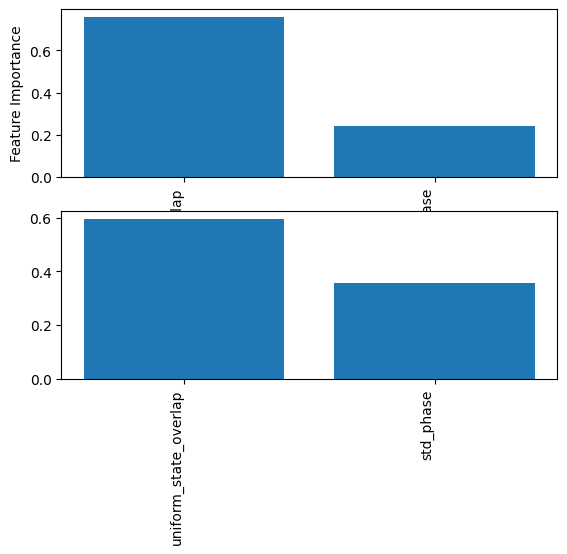

In [36]:
fig, ax = plt.subplots(2)
scores = mutual_info_regression(X_train, y_train)

ax[0].bar(features, xgbmodel.feature_importances_)  # This does permutation importance i.e swap features and see drop in performance
ax[0].set_xticklabels(features, rotation=90, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, scores)
ax[1].set_xticklabels(features, rotation=90, ha='right')

In [12]:
# # Create a dataframe where each complex element of psi_0 is split into amplitude and phase
# # Extract amplitude (magnitude) and phase for each element
# psi_0_amp_phase = []

# for psi_vector in df_opt['psi_0']:
#     psi_complex = np.asarray(psi_vector)
#     amp = np.abs(psi_complex)
#     phase = np.angle(psi_complex)
#     psi_0_amp_phase.append(np.concatenate([amp, phase]))

# # Create dataframe with amplitude and phase columns
# psi_0_expanded = pd.DataFrame(psi_0_amp_phase)
# n_elements = len(np.asarray(df_opt['psi_0'].iloc[0]))
# amp_cols = [f'psi_0_{i}_amp' for i in range(n_elements)]
# phase_cols = [f'psi_0_{i}_phase' for i in range(n_elements)]
# psi_0_expanded.columns = amp_cols + phase_cols

# # Combine with Delta_E target
# df_psi = pd.concat([psi_0_expanded, df_opt[['Delta_E']].reset_index(drop=True)], axis=1)

# # Remove rows with NaN values
# df_psi = df_psi.dropna()

# print(f"DataFrame shape: {df_psi.shape}")
# print(f"Total features (amplitude + phase): {len(amp_cols + phase_cols)}")
# print(f"Columns: {psi_0_expanded.columns.tolist()[:10]}... (showing first 10)")
# print(f"\nTarget (Delta_E) statistics:")
# print(df_psi['Delta_E'].describe())

In [13]:
# # Split into train/validation/test and train XGBoost with early stopping
# X_psi = df_psi.drop('Delta_E', axis=1)
# y_psi = df_psi['Delta_E']

# # First split: 60% train, 40% test
# X_train_psi, X_test_psi, y_train_psi, y_test_psi = train_test_split(
#     X_psi, y_psi, test_size=0.2, random_state=42
# )

# # Further split train into train/validation: 75% train, 25% validation
# X_train_psi, X_val_psi, y_train_psi, y_val_psi = train_test_split(
#     X_train_psi, y_train_psi, test_size=0.25, random_state=42
# )

# print(f"Training set size: {X_train_psi.shape[0]}")
# print(f"Validation set size: {X_val_psi.shape[0]}")
# print(f"Test set size: {X_test_psi.shape[0]}")
# print(f"Number of features (psi_0 amplitude + phase): {X_train_psi.shape[1]}")

# # Train XGBoost model with early stopping
# xgb_model_psi = XGBRegressor(
#     n_estimators=1000,
#     random_state=42,
#     learning_rate=0.01,
#     max_depth=7,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     early_stopping_rounds=50,
#     verbose=False
# )

# xgb_model_psi.fit(
#     X_train_psi, y_train_psi,
#     eval_set=[(X_val_psi, y_val_psi)],
#     verbose=False
# )

# # Evaluate on test set
# y_pred_psi = xgb_model_psi.predict(X_test_psi)
# mse_psi = mean_squared_error(y_test_psi, y_pred_psi)

# print(f"\nXGBoost (psi_0 amplitude + phase as features)")
# print(f"Best iteration: {xgb_model_psi.best_iteration}")
# print(f"Mean Squared Error: {mse_psi}")
# print(f"R² Score (Test): {xgb_model_psi.score(X_test_psi, y_test_psi):.4f}")
# print(f"RMSE: {np.sqrt(mse_psi):.6f}")
# print(f"Mean Absolute Error: {np.mean(np.abs(y_test_psi - y_pred_psi)):.6f}")

In [14]:
# # Visualize predictions vs actual
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # Scatter plot
# ax1.scatter(y_test_psi, y_pred_psi, alpha=0.5)
# ax1.set_xlabel('True Delta E')
# ax1.set_ylabel('Predicted Delta E')
# ax1.set_title('Predictions vs Actual (psi_0 features)')
# ax1.plot([y_test_psi.min(), y_test_psi.max()], [y_test_psi.min(), y_test_psi.max()], 'r--', lw=2)
# ax1.grid(True, alpha=0.3)

# # Residuals
# residuals = y_test_psi - y_pred_psi
# ax2.scatter(y_pred_psi, residuals, alpha=0.5)
# ax2.axhline(y=0, color='r', linestyle='--', lw=2)
# ax2.set_xlabel('Predicted Delta E')
# ax2.set_ylabel('Residuals')
# ax2.set_title('Residual Plot')
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print(f"Residual mean: {residuals.mean():.6f}")
# print(f"Residual std: {residuals.std():.6f}")

In [21]:
len(traindf)
len(df_opt['idx'].unique()), len(df_opt)

(700, 700)